In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [27]:
import matplotlib
matplotlib.use('Agg')

In [28]:
# LIBRARIES
import tensorflow as tf
import numpy as np
from copy import deepcopy
import random 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tkinter import *

In [4]:
#initialize a new game
def new_game(n):
    matrix = np.zeros([n,n])
    return matrix

#add 2 or 4 in the matrix
def add_two(mat):
    empty_cells = []
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if(mat[i][j]==0):
                empty_cells.append((i,j))
    if(len(empty_cells)==0):
        return mat
    
    index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]
    
    prob = random.random()
    if(prob>=0.9):
        mat[index_pair[0]][index_pair[1]]=4
    else:
        mat[index_pair[0]][index_pair[1]]=2
    return mat

#to check state of the game
def game_state(mat):
    #if 2048 in mat:
    #    return 'win'
    
    for i in range(len(mat)-1): #intentionally reduced to check the row on the right and below
        for j in range(len(mat[0])-1): #more elegant to use exceptions but most likely this will be their solution
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'not over'
            
    for i in range(len(mat)): #check for any zero entries
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'not over'
            
    for k in range(len(mat)-1): #to check the left/right entries on the last row
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'not over'
        
    for j in range(len(mat)-1): #check up/down entries on last column
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'not over'
        
    return 'lose'


def reverse(mat):
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    new=[]
    for i in range(len(mat[0])):
        new.append([])
        for j in range(len(mat)):
            new[i].append(mat[j][i])
            
    return np.transpose(mat)

def cover_up(mat):
    new = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if mat[i][j]!=0:
                new[i][count] = mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return (new,done)

def merge(mat):
    done=False
    score = 0
    for i in range(4):
        for j in range(3):
            if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                mat[i][j]*=2
                score += mat[i][j]   
                mat[i][j+1]=0
                done=True
    return (mat,done,score)

#up move
def up(game):
        game = transpose(game)
        game,done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(game)
        return (game,done,temp[2])

#down move
def down(game):
        game=reverse(transpose(game))
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=transpose(reverse(game))
        return (game,done,temp[2])

#left move
def left(game):
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        return (game,done,temp[2])

#right move
def right(game):
        game=reverse(game)
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=reverse(game)
        return (game,done,temp[2])

# Controls

In [5]:
controls = {0:up,1:left,2:right,3:down}

# Important Functions

In [6]:
#convert the input game matrix into corresponding power of 2 matrix.
def change_values(X):
    power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][i][j][power] = 1.0
    return power_mat        

#find the number of empty cells in the game matrix.
def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

# Hyperparameters

In [7]:
#hyper parameters
start_learning_rate = 0.0005

#gamma for Q-learning
gamma = 0.9

#epsilon greedy approach
epsilon = 0.9

#to store states and lables of the game for training
#states of the game
replay_memory = list()

#labels of the states
replay_labels = list()

#capacity of memory
mem_capacity = 6000

In [8]:
#first convolution layer depth
depth1 = 128

#second convolution layer depth
depth2 = 128

#batch size for batch gradient descent
batch_size = 512

#input units
input_units = 16

#fully connected layer neurons
hidden_units = 256

#output neurons = number of moves
output_units = 4

# Tensorflow Graph

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
#input data
tf_batch_dataset = tf.placeholder(tf.float32,shape=(batch_size,4,4,16))
tf_batch_labels  = tf.placeholder(tf.float32,shape=(batch_size,output_units))

single_dataset   = tf.placeholder(tf.float32,shape=(1,4,4,16))


#CONV LAYERS
#conv layer1 weights
conv1_layer1_weights = tf.Variable(tf.truncated_normal([1,2,input_units,depth1],mean=0,stddev=0.01))
conv2_layer1_weights = tf.Variable(tf.truncated_normal([2,1,input_units,depth1],mean=0,stddev=0.01))

#conv layer2 weights
conv1_layer2_weights = tf.Variable(tf.truncated_normal([1,2,depth1,depth2],mean=0,stddev=0.01))
conv2_layer2_weights = tf.Variable(tf.truncated_normal([2,1,depth1,depth2],mean=0,stddev=0.01))

#conv layer1 biases

#FUllY CONNECTED LAYERS
expand_size = 2*4*depth2*2 + 3*3*depth2*2 + 4*3*depth1*2
fc_layer1_weights = tf.Variable(tf.truncated_normal([expand_size,hidden_units],mean=0,stddev=0.01))
fc_layer1_biases = tf.Variable(tf.truncated_normal([1,hidden_units],mean=0,stddev=0.01))
fc_layer2_weights = tf.Variable(tf.truncated_normal([hidden_units,output_units],mean=0,stddev=0.01))
fc_layer2_biases = tf.Variable(tf.truncated_normal([1,output_units],mean=0,stddev=0.01))


#model
def model(dataset):
    #layer1
    conv1 = tf.nn.conv2d(dataset,conv1_layer1_weights,[1,1,1,1],padding='VALID') 
    conv2 = tf.nn.conv2d(dataset,conv2_layer1_weights,[1,1,1,1],padding='VALID') 
    
    #layer1 relu activation
    relu1 = tf.nn.relu(conv1)
    relu2 = tf.nn.relu(conv2)
    
    #layer2
    conv11 = tf.nn.conv2d(relu1,conv1_layer2_weights,[1,1,1,1],padding='VALID') 
    conv12 = tf.nn.conv2d(relu1,conv2_layer2_weights,[1,1,1,1],padding='VALID') 

    conv21 = tf.nn.conv2d(relu2,conv1_layer2_weights,[1,1,1,1],padding='VALID') 
    conv22 = tf.nn.conv2d(relu2,conv2_layer2_weights,[1,1,1,1],padding='VALID') 

    #layer2 relu activation
    relu11 = tf.nn.relu(conv11)
    relu12 = tf.nn.relu(conv12)
    relu21 = tf.nn.relu(conv21)
    relu22 = tf.nn.relu(conv22)
    
    #get shapes of all activations
    shape1 = relu1.get_shape().as_list()
    shape2 = relu2.get_shape().as_list()
    
    shape11 = relu11.get_shape().as_list()
    shape12 = relu12.get_shape().as_list()
    shape21 = relu21.get_shape().as_list()
    shape22 = relu22.get_shape().as_list()

    #expansion
    hidden1 = tf.reshape(relu1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
    hidden2 = tf.reshape(relu2,[shape2[0],shape2[1]*shape2[2]*shape2[3]])
    
    hidden11 = tf.reshape(relu11,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
    hidden12 = tf.reshape(relu12,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
    hidden21 = tf.reshape(relu21,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
    hidden22 = tf.reshape(relu22,[shape22[0],shape22[1]*shape22[2]*shape22[3]])

    #concatenation
    hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)

    #full connected layers
    hidden = tf.matmul(hidden,fc_layer1_weights) + fc_layer1_biases
    hidden = tf.nn.relu(hidden)

    #output layer
    output = tf.matmul(hidden,fc_layer2_weights) + fc_layer2_biases
    
    #return output
    return output

#for single example
single_output = model(single_dataset)

#for batch data
logits = model(tf_batch_dataset)

#loss
loss = tf.square(tf.subtract(tf_batch_labels,logits))
loss = tf.reduce_sum(loss,axis=1,keep_dims=True)
loss = tf.reduce_mean(loss)/2.0

#optimizer
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(float(start_learning_rate), global_step, 1000, 0.90, staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
#loss
J = []

#scores
scores = []

#to store final parameters
final_parameters = {}

#number of episodes
M = 10000

Create training dataset and Train Simultaneously
* Current Reward = number of merges + log(new max,2)

In [12]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    
    global epsilon
    global replay_labels
    global replay_memory

    #for episode with max score
    maximum = -1
    episode = -1
    
    #total_iters 
    total_iters = 1
    
    #number of back props
    back=0
    
    for ep in range(M):
        global board
        board = new_game(4)
        add_two(board)
        add_two(board)
        
        #whether episode finished or not
        finish = 'not over'
        
        #total_score of this episode
        total_score = 0
        
        #iters per episode
        local_iters = 1
        
        while(finish=='not over'):
            prev_board = deepcopy(board)
            
            #get the required move for this state
            state = deepcopy(board)
            state = change_values(state)
            state = np.array(state,dtype = np.float32).reshape(1,4,4,16)
            feed_dict = {single_dataset:state}
            control_scores = session.run(single_output,feed_dict=feed_dict)
            
            #find the move with max Q value
            control_buttons = np.flip(np.argsort(control_scores),axis=1)
            
            #copy the Q-values as labels
            labels = deepcopy(control_scores[0])
            
            #generate random number for epsilon greedy approach
            num = random.uniform(0,1)
            
            #store prev max
            prev_max = np.max(prev_board)
            
            #num is less epsilon generate random move
            if(num<epsilon):
                #find legal moves
                legal_moves = list()
                for i in range(4):
                    temp_board = deepcopy(prev_board)
                    temp_board,_,_ = controls[i](temp_board)
                    if(np.array_equal(temp_board,prev_board)):
                        continue
                    else:
                        legal_moves.append(i)
                if(len(legal_moves)==0):
                    finish = 'lose'
                    continue
                
                #generate random move.
                con = random.sample(legal_moves,1)[0]
                
                #apply the move
                temp_state = deepcopy(prev_board)
                temp_state,_,score = controls[con](temp_state)
                total_score += score
                finish = game_state(temp_state)
                
                #get number of merges
                empty1 = findemptyCell(prev_board)
                empty2 = findemptyCell(temp_state)
                
                if(finish=='not over'):
                    temp_state = add_two(temp_state)

                board = deepcopy(temp_state)

                #get next max after applying the move
                next_max = np.max(temp_state)
                
                #reward math.log(next_max,2)*0.1 if next_max is higher than prev max
                labels[con] = (math.log(next_max,2))*0.1
                
                if(next_max==prev_max):
                    labels[con] = 0
                
                #reward is also the number of merges
                labels[con] += (empty2-empty1)
                
                #get the next state max Q-value
                temp_state = change_values(temp_state)
                temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                feed_dict = {single_dataset:temp_state}
                temp_scores = session.run(single_output,feed_dict=feed_dict)
                    
                max_qvalue = np.max(temp_scores)
                
                #final labels add gamma*max_qvalue
                labels[con] = (labels[con] + gamma*max_qvalue)
            
            #generate the the max predicted move
            else:
                for con in control_buttons[0]:
                    prev_state = deepcopy(prev_board)
                    
                    #apply the LEGAl Move with max q_value
                    temp_state,_,score = controls[con](prev_state)
                    
                    #if illegal move label = 0
                    if(np.array_equal(prev_board,temp_state)):
                        labels[con] = 0
                        continue
                        
                    #get number of merges
                    empty1 = findemptyCell(prev_board)
                    empty2 = findemptyCell(temp_state)

                    
                    temp_state = add_two(temp_state)
                    board = deepcopy(temp_state)
                    total_score += score

                    next_max = np.max(temp_state)
                    
                    #reward
                    labels[con] = (math.log(next_max,2))*0.1
                    if(next_max==prev_max):
                        labels[con] = 0
                    
                    labels[con] += (empty2-empty1)

                    #get next max qvalue
                    temp_state = change_values(temp_state)
                    temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                    feed_dict = {single_dataset:temp_state}
                    temp_scores = session.run(single_output,feed_dict=feed_dict)

                    max_qvalue = np.max(temp_scores)

                    #final labels
                    labels[con] = (labels[con] + gamma*max_qvalue)
                    break
                    
                if(np.array_equal(prev_board,board)):
                    finish = 'lose'
            
            #decrease the epsilon value
            if((ep>10000) or (epsilon>0.1 and total_iters%2500==0)):
                epsilon = epsilon/1.005
                
           
            #change the matrix values and store them in memory
            prev_state = deepcopy(prev_board)
            prev_state = change_values(prev_state)
            prev_state = np.array(prev_state,dtype=np.float32).reshape(1,4,4,16)
            replay_labels.append(labels)
            replay_memory.append(prev_state)
            
            
            #back-propagation
            if(len(replay_memory)>=mem_capacity):
                back_loss = 0
                batch_num = 0
                z = list(zip(replay_memory,replay_labels))
                np.random.shuffle(z)
                np.random.shuffle(z)
                replay_memory,replay_labels = zip(*z)
                
                for i in range(0,len(replay_memory),batch_size):
                    if(i + batch_size>len(replay_memory)):
                        break
                        
                    batch_data = deepcopy(replay_memory[i:i+batch_size])
                    batch_labels = deepcopy(replay_labels[i:i+batch_size])
                    
                    batch_data = np.array(batch_data,dtype=np.float32).reshape(batch_size,4,4,16)
                    batch_labels = np.array(batch_labels,dtype=np.float32).reshape(batch_size,output_units)
                
                    feed_dict = {tf_batch_dataset: batch_data, tf_batch_labels: batch_labels}
                    _,l = session.run([optimizer,loss],feed_dict=feed_dict)
                    back_loss += l 
                    
                    print("Mini-Batch - {} Back-Prop : {}, Loss : {}".format(batch_num,back,l))
                    batch_num +=1
                back_loss /= batch_num
                J.append(back_loss)
                
                #store the parameters in a dictionary
                final_parameters['conv1_layer1_weights'] = session.run(conv1_layer1_weights)
                final_parameters['conv1_layer2_weights'] = session.run(conv1_layer2_weights)
                final_parameters['conv2_layer1_weights'] = session.run(conv2_layer1_weights)
                final_parameters['conv2_layer2_weights'] = session.run(conv2_layer2_weights)
                final_parameters['fc_layer1_weights'] = session.run(fc_layer1_weights)
                final_parameters['fc_layer2_weights'] = session.run(fc_layer2_weights)
                final_parameters['fc_layer1_biases'] = session.run(fc_layer1_biases)
                final_parameters['fc_layer2_biases'] = session.run(fc_layer2_biases)
                
                #number of back-props
                back+=1
                
                #make new memory 
                replay_memory = list()
                replay_labels = list()
                
            
            if(local_iters%400==0):
                print("Episode : {}, Score : {}, Iters : {}, Finish : {}".format(ep,total_score,local_iters,finish))
            
            local_iters += 1
            total_iters += 1
            
        scores.append(total_score)
        print("Episode {} finished with score {}, result : {} board : {}, epsilon  : {}, learning rate : {} ".format(ep,total_score,finish,board,epsilon,session.run(learning_rate)))
        print()
        
        if((ep+1)%1000==0):
            print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    
            print("Loss : {}".format(J[len(J)-1]))
            print()
            
        if(maximum<total_score):
            maximum = total_score
            episode = ep
    print("Maximum Score : {} ,Episode : {}".format(maximum,episode))


path = r'/content/MyDrive/MyDrive/RL/Weights/10000'
weights = ['conv1_layer1_weights','conv1_layer2_weights','conv2_layer1_weights','conv2_layer2_weights','fc_layer1_weights','fc_layer1_biases','fc_layer2_weights','fc_layer2_biases']
for w in weights:
    flatten = final_parameters[w].reshape(-1,1)
    file = open(path + '/' + w +'.csv','w')
    file.write('Sno,Weight\n')
    for i in range(flatten.shape[0]):
        file.write(str(i) +',' +str(flatten[i][0])+'\n') 
    file.close()
    print(w + " written!")

Streaming output truncated to the last 5000 lines.
 [  2.  32.  16.   2.]], epsilon  : 0.09977213709935216, learning rate : 0.00040499999886378646 

Episode 8714 finished with score 2908.0, result : lose board : [[  2.  16.   4.   2.]
 [ 16. 256.   8.   4.]
 [ 32.  16. 128.  32.]
 [  2.   8.   4.   2.]], epsilon  : 0.09977213709935216, learning rate : 0.00040499999886378646 

Episode 8715 finished with score 784.0, result : lose board : [[2.0, 16.0, 8.0, 4], [32.0, 64.0, 16.0, 8.0], [2.0, 16.0, 32.0, 4.0], [8.0, 4.0, 16.0, 2.0]], epsilon  : 0.09977213709935216, learning rate : 0.00040499999886378646 

Episode 8716 finished with score 1592.0, result : lose board : [[16.0, 8.0, 4.0, 2], [2.0, 16.0, 64.0, 8.0], [128.0, 64.0, 8.0, 4.0], [16.0, 2.0, 16.0, 2.0]], epsilon  : 0.09977213709935216, learning rate : 0.00040499999886378646 

Episode 8717 finished with score 3096.0, result : lose board : [[ 64.   2.   4.   2.]
 [  4. 256.  32.   8.]
 [128.  32.  16.   4.]
 [  4.   2.   4.   2.]], ep

Store Trained Weights in a folder

In [13]:
path = r'/content/MyDrive/MyDrive/RL/Weights/Saved'
weights = ['conv1_layer1_weights','conv1_layer2_weights','conv2_layer1_weights','conv2_layer2_weights','fc_layer1_weights','fc_layer1_biases','fc_layer2_weights','fc_layer2_biases']
for w in weights:
    flatten = final_parameters[w].reshape(-1,1)
    file = open(path + '/' + w +'.csv','w')
    file.write('Sno,Weight\n')
    for i in range(flatten.shape[0]):
        file.write(str(i) +',' +str(flatten[i][0])+'\n') 
    file.close()
    print(w + " written!")

conv1_layer1_weights written!
conv1_layer2_weights written!
conv2_layer1_weights written!
conv2_layer2_weights written!
fc_layer1_weights written!
fc_layer1_biases written!
fc_layer2_weights written!
fc_layer2_biases written!


Store J and scores too

In [14]:
import pickle
fp = open("/content/MyDrive/MyDrive/RL/Weights/Saved/J", "wb")   #Pickling
pickle.dump(J, fp)

fp = open("/content/MyDrive/MyDrive/RL/Weights/Saved/scores", "wb")  #Pickling
pickle.dump(scores, fp)
 
# open_file = open(file_name, "rb")
# loaded_list = pickle.load(open_file)

Evaluating Performance

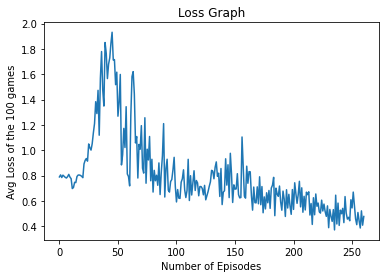

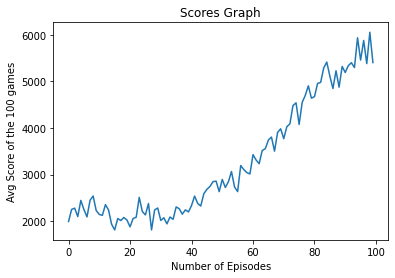

8104.0 9811


In [15]:
# plot of scores performance
import matplotlib.pyplot as plt
avg_scores = []
summ = 0
for index,value in enumerate(scores):
    if((index+1)%100==0):
        avg_scores.append(summ/50)
        summ=0
    summ+=value
plt.figure()
# Add title and axis names
plt.title('Loss Graph')
plt.xlabel('Number of Episodes')
plt.ylabel('Avg Loss of the 100 games')
plt.plot(list(range(len(J)-1)),J[1:])
plt.savefig('/content/MyDrive/MyDrive/RL/Weights/Saved/loss_graph.png')
plt.show()
# Add title and axis names
plt.title('Scores Graph')
plt.xlabel('Number of Episodes')
plt.ylabel('Avg Score of the 100 games')
plt.plot(list(range(len(avg_scores))),avg_scores)
plt.savefig('/content/MyDrive/MyDrive/RL/Weights/Saved/scores_graph.png')
plt.show()
print(np.max(scores),np.argmax(scores))